Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

from import_data import load_data

Import data

In [2]:
listVideo = load_data('../data_luc/video/')

nbVideos = len(listVideo)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))

   configurationID  H264  no_8x8dct  no_asm  no_cabac  no_deblock  \
0                1  True       True   False     False        True   
1               10  True       True   False      True       False   
2              100  True       True   False     False        True   
3             1000  True       True   False      True       False   
4             1001  True      False   False     False        True   

   no_fast_pskip  no_mbtree  no_mixed_refs  no_weightb  rc_lookahead  ref  \
0           True      False           True        True            20    9   
1           True      False          False        True            40    9   
2          False       True           True       False            40    1   
3           True       True           True       False            40    9   
4          False      False           True       False            60    5   

      size  usertime  systemtime  elapsedtime  
0  1718492   22.9416      0.2784       3.1876  
1  1962957   26.8176      

## 2) Model shifting implementation

##### MS function

In [14]:
def model_shift(source_id, target_id, nb_config_target_training,
                features, predictedVar, learning_algorithm, shift_function):
    
    # the percentage (proportion) of configurations used for the test
    pct_test = 1-nb_config_target_training/listVideo[target_id].size
    
    # random state , i.e. a seed to split the source and the target datasets
    # by using the same set of configurations for training and testing
    random_state = np.random.randint(0,1000)
    
    # We define the source video, and split it into train-test
    source = listVideo[source_id]
    X_src = source[features] 
    y_src = np.array(source[predictedVar], dtype=float)
    X_src_train, X_src_test, y_src_train, y_src_test = train_test_split(X_src, 
                                                                        y_src, 
                                                                        test_size=pct_test,
                                                                        random_state=random_state)
    # We define the target video, and split it into train-test
    target = listVideo[target_id]
    X_tgt = target[features] 
    y_tgt = np.array(target[predictedVar], dtype=float)
    X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test = train_test_split(X_tgt, 
                                                                        y_tgt, 
                                                                        test_size=pct_test, 
                                                                        random_state=random_state)
    
    # The learning algorithm, training on the source video
    X_src_train2, _, y_src_train2, _ = train_test_split(X_src, y_src, 
                                                        test_size=0.2,
                                                        random_state=random_state)
    lf = learning_algorithm()
    lf.fit(X_src_train2, y_src_train2)
    y_src_pred_test = np.array(lf.predict(X_src_test)).reshape(-1,1)
    
    # The shift function, to transfer the prediction from the source to the target
    shift = shift_function()
    shift.fit(np.array(y_src_train).reshape(-1,1), y_tgt_train)
    y_tgt_pred_test = shift.predict(y_src_pred_test)
    
    # We return the mean average percentage error 
    # between the real values of y_test from target 
    # and the predictions shifted 
    return min(mape(y_tgt_test, y_tgt_pred_test),1)


# run test
model_shift(source_id = 1,
            target_id = 2, 
            features = ['no_8x8dct','no_asm', 'no_cabac','no_deblock','no_fast_pskip',
     'no_mbtree','no_mixed_refs','no_weightb','rc_lookahead','ref'], 
            predictedVar = 'elapsedtime', 
            learning_algorithm = RandomForestRegressor,
            shift_function = LinearRegression,
            nb_config_target_training = 32)

0.07602908127324373

#### Test it for different videos, and nb_config

In [15]:
features = ['no_8x8dct','no_asm', 'no_cabac','no_deblock','no_fast_pskip',
     'no_mbtree','no_mixed_refs','no_weightb','rc_lookahead','ref']
predictedVar = 'elapsedtime'
nb_config = [16, 32, 64, 128, 256, 320, 448, 640, 960]
learning_algorithm = LinearRegression
shift_function = LinearRegression

res_model_shift = pd.DataFrame({'id_video' : range(nbVideos)})

for conf in nb_config:

    mat_mape_ms = np.ones(nbVideos*nbVideos).reshape(nbVideos, nbVideos)

    for i in range(nbVideos):
        for j in range(nbVideos):
            mat_mape_ms[i][j] = model_shift(source_id = i,
                        target_id = j, 
                        nb_config_target_training = conf, 
                        features = ['no_8x8dct','no_asm', 'no_cabac',
                                    'no_deblock','no_fast_pskip','no_mbtree',
                                    'no_mixed_refs','no_weightb','rc_lookahead','ref'], 
                        predictedVar = 'elapsedtime',
                        learning_algorithm = learning_algorithm,
                        shift_function = shift_function)

    mean_video = []
    for k in range(len(mat_mape_ms)):
        mean_video.append(np.mean(mat_mape_ms[:,k]))

    res_model_shift[str(conf)] = mean_video

In [11]:
res = res_model_shift.set_index('id_video')
res.to_csv("../data_luc/res/res_model_shift_nb_conf_training.csv")
res

,16,32,64,128,256,320,448,640,960
id_video,,,,,,,,,
0,0.361482,0.425520,0.228673,0.148129,0.150829,0.156162,0.157055,0.152991,0.149534
1,0.317475,0.384374,0.128809,0.113141,0.106644,0.104268,0.103656,0.101731,0.102283
2,0.252538,0.350289,0.142696,0.126010,0.119088,0.116285,0.115538,0.113936,0.113955
3,0.325381,0.284299,0.149335,0.127426,0.118019,0.120211,0.119607,0.120057,0.118586
4,0.278777,0.134259,0.100482,0.087839,0.086728,0.086005,0.085378,0.085255,0.084971
5,0.320823,0.288422,0.118804,0.114824,0.107693,0.104819,0.106013,0.104908,0.104299
6,0.272983,0.250381,0.121038,0.100037,0.092099,0.091578,0.090548,0.089718,0.089222
7,0.295115,0.222495,0.119663,0.104679,0.088400,0.085282,0.086184,0.085874,0.084719
8,0.255519,0.230762,0.148704,0.092086,0.088258,0.087892,0.086743,0.086741,0.085870


In [6]:
def plot_dendogram(corr, img_name, method, ticks, div=False, title=''):

    df = pd.DataFrame(corr)
    
    sns.clustermap(df, cmap="vlag", method=method,
               linewidths=.75, figsize=(13, 13), cbar_kws={"ticks":ticks})
    plt.title(title)
    plt.savefig(img_name)
    plt.show()

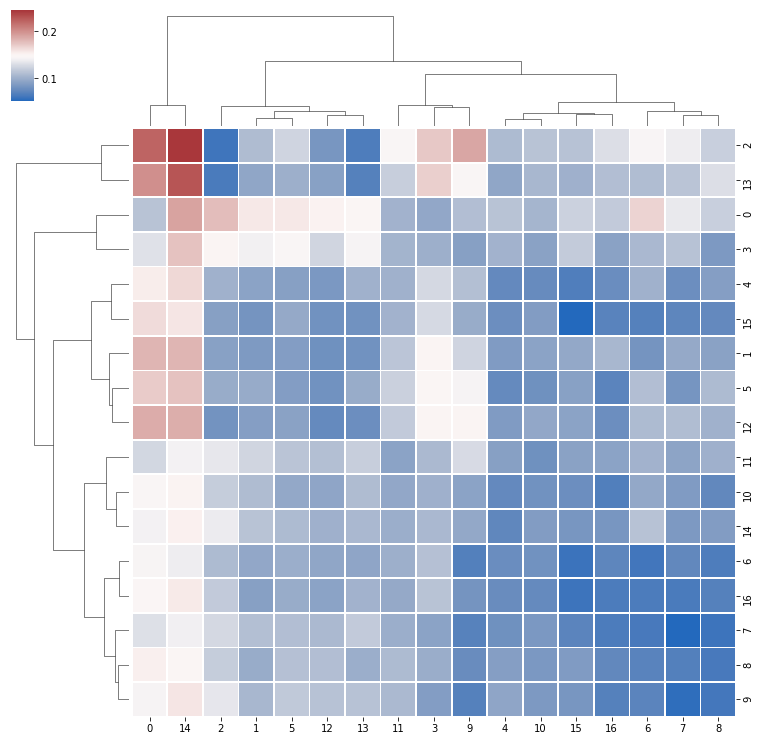

In [8]:
method = 'ward'
plot_dendogram(mat_mape_ms, 
               "../results/mape_score_ms.pdf",
               method, 
               [k/10 for k in range(11)],
               div=True)